In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os 
import seaborn as sns 

In [2]:
print(os.listdir(r'../input/brain-mri-images-for-brain-tumor-detection'))

['no', 'yes', 'brain_tumor_dataset']


In [3]:
size=128
images=[]
labels=[]
#0 for normal, 1 for tumour

for root,dirs,files in os.walk('../input/brain-mri-images-for-brain-tumor-detection/yes'):
    for file in files:
        if 'jpg' in file:
            img=cv2.imread(os.path.join(root,file))
            img= cv2.resize(img,(size,size))
            images.append(img)
            labels.append(1)
            
for root,dirs,files in os.walk('../input/brain-mri-images-for-brain-tumor-detection/no'):
    for file in files:
        if 'jpg' in file:
            img=cv2.imread(os.path.join(root,file))
            img= cv2.resize(img,(size,size))
            images.append(img)
            labels.append(0)
            
images=np.array(images)
labels=np.array(labels)
            

            
            

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.3)
X_train=X_train/255
X_test=X_test/255
    

In [5]:
X_train.shape

(119, 128, 128, 3)

In [6]:
#Creating a custom CNN:
feature_extractor= Sequential()
feature_extractor.add(Conv2D(32,3,activation='relu',padding='same',input_shape=(128,128,3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64,3,activation='relu',padding='same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64,3,activation='relu',padding='same'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(128,3,activation='relu',padding='same'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())
x=Dense(128, activation='relu')(feature_extractor.output)
pred= Dense(1, activation='sigmoid')(x)

model=Model(inputs=feature_extractor.input,outputs=pred)
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
history= model.fit(X_train, y_train, epochs=120, validation_data=(X_test,y_test),batch_size=64)


2022-06-30 15:26:10.117992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 15:26:10.209436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 15:26:10.210331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 15:26:10.211621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/120


2022-06-30 15:26:14.745410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2/2 [==============================] - 10s 2s/step - loss: 216.3761 - accuracy: 0.5294 - val_loss: 2.1042 - val_accuracy: 0.4423
Epoch 2/120
2/2 [==============================] - 0s 100ms/step - loss: 88.7617 - accuracy: 0.5462 - val_loss: 0.8291 - val_accuracy: 0.5769
Epoch 3/120
2/2 [==============================] - 0s 96ms/step - loss: 15.4029 - accuracy: 0.5126 - val_loss: 0.7395 - val_accuracy: 0.6731
Epoch 4/120
2/2 [==============================] - 0s 95ms/step - loss: 3.8394 - accuracy: 0.7899 - val_loss: 0.9166 - val_accuracy: 0.7115
Epoch 5/120
2/2 [==============================] - 0s 95ms/step - loss: 1.2548 - accuracy: 0.7983 - val_loss: 1.3643 - val_accuracy: 0.7500
Epoch 6/120
2/2 [==============================] - 0s 95ms/step - loss: 1.2716 - accuracy: 0.7815 - val_loss: 1.8744 - val_accuracy: 0.7692
Epoch 7/120
2/2 [==============================] - 0s 94ms/step - loss: 0.2473 - accuracy: 0.9496 - val_loss: 2.4489 - val_accuracy: 0.6923
Epoch 8/120
2/2 [===========

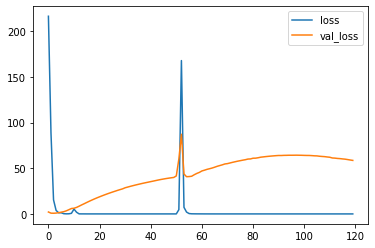

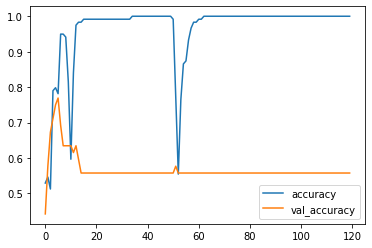

In [7]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

From these plots, we can see that there is an issue with the model - the validation accuracy is not increasing despite the fact the loss has decreased. This is most likely due to overfitting the data. One way we could solve this is by adding more training data, which could help decrease the variance. This could be done by augmenting the data, i.e changing the image slightly, so there is more data for the model to learn on but it is not hugely changed (e.g rotating by an angle)

In [8]:
from keras.applications.vgg16 import VGG16

VGG_model= VGG16(weights='imagenet',include_top=False, input_shape=(size,size,3))
for layer in VGG_model.layers:
    layer.trainable=False

    

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
feature_extractor=VGG_model.predict(X_train)
features= feature_extractor.reshape(feature_extractor.shape[0],-1) #input for random forest needs to be 2D array (no. of samples, )

In [10]:
features.shape #confirmed in the correct format

(119, 8192)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf= RandomForestClassifier(n_estimators=50)
rf.fit(features, y_train)
x_test_features= VGG_model.predict(X_test)
x_test_feature=x_test_features.reshape(x_test_features.shape[0],-1)
pred= rf.predict(x_test_feature)
print (f'Accuracy={metrics.accuracy_score(y_test,pred)}')

Accuracy=0.8269230769230769
